In [1]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from math import log, sqrt
import pandas as pd
import numpy as np

In [2]:
# read data from the .csv file
messages = pd.read_csv('../input/spam-or-ham/spam.csv', encoding = 'latin-1')
messages.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
# get rid of the unnecessary columns in the data frame
messages.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1, inplace = True)
# rename columns
messages.rename(columns = {'v1': 'labels', 'v2': 'text'}, inplace = True)

# creates a new index/column with new labels for each type
messages['label'] = messages['labels'].map({'ham': 0, 'spam': 1})
# drop original labels column
messages.drop(['labels'], axis = 1, inplace = True)

messages.head()

,text,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [4]:
# shuffle the data so you can train 
messages = messages.sample(frac=1).reset_index(drop=True)
messages.head()

,text,label
0,I HAVE A DATE ON SUNDAY WITH WILL!!,0
1,*deep sigh* ... I miss you :-( ... I am really...,0
2,Yeah that'd pretty much be the best case scenario,0
3,"Sir, I am waiting for your mail.",0
4,His bday real is in april .,0


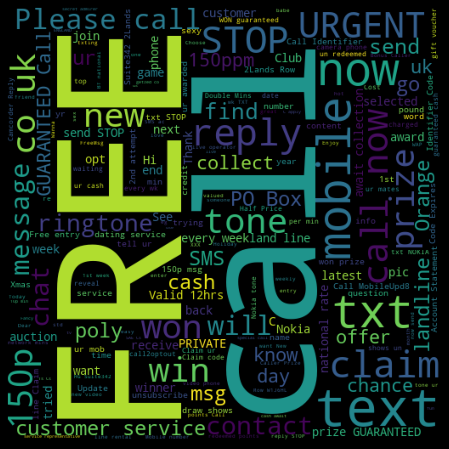

In [5]:
# create corresponding wordcloud image for spam dataset to get an idea of most frequently used words
allSpamMessagesStr = ' '.join(list(messages[messages['label'] == 1]['text']))
spamWc = WordCloud(width = 512, height = 512).generate(allSpamMessagesStr)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(spamWc)
plt.axis('off')
plt.show()

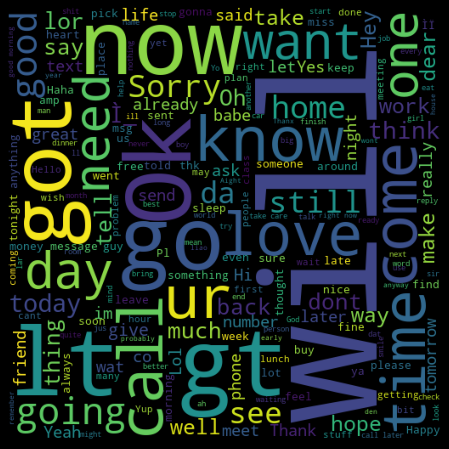

In [6]:
# create corresponding wordcloud image for ham dataset to get an idea of most frequently used words
allHamMessagesStr = ' '.join(list(messages[messages['label'] == 0]['text']))
hamWc = WordCloud(width = 512, height = 512).generate(allHamMessagesStr)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(hamWc)
plt.axis('off')
plt.show()

In [7]:
def tokenizeMessage(message):
    tokenized = word_tokenize(message.lower())
    stopWords = stopwords.words('english')
    tokenized = [w for w in tokenized if not w in stopWords]
    porterStemmer = PorterStemmer()
    tokenized = [porterStemmer.stem(w) for w in tokenized]
    return tokenized

In [8]:
# collect TF-IDF data
numMessages = int(messages['text'].size * 0.75)
numSpamMessages, numHamMessages = 0, 0
tfSpam = dict() # term frequency of each item in spam dataset
tfHam = dict() # term frequency of each item in ham dataset
occurencesSpam = dict() # calculates total # of messages containing 'word' in spam dataset
occurencesHam = dict() # calculates total # of messages containing 'word' in ham dataset
for i in range(numMessages):
    # incremenet
    if (messages['label'][i] == 1):
        numSpamMessages += 1
    else:
        numHamMessages += 1
    tokenizedMessage = tokenizeMessage(messages['text'][i])
    vocabulary = set()
    for word in tokenizedMessage:
        if (messages['label'][i] == 1):
            tfSpam[word] = tfSpam.get(word, 0) + 1
        else:
            tfHam[word] = tfHam.get(word, 0) + 1
        if word not in vocabulary:
            vocabulary.add(word)
    for word in vocabulary:
        if (messages['label'][i] == 1):
            occurencesSpam[word] = occurencesSpam.get(word, 0) + 1
        else:
            occurencesHam[word] = occurencesHam.get(word, 0) + 1

# calculate IDF using the occurences dictionary
idfSpam = dict()
idfHam = dict()
for word in occurencesSpam:
    idfSpam[word] = log(numSpamMessages / occurencesSpam[word])
for word in occurencesHam:
    idfHam[word] = log(numHamMessages / occurencesHam[word])
    
# calculate P(w | spam) and P(w | ham) for words that were found in those corresponding datasets
pWordSpam = dict()
pWordHam = dict()
tfIdfSumSpam = 0
tfIdfSumHam = 0
# set pWord originally equal to just the TF-IDF score and keep track of sum of T
for word in idfSpam:
    pWordSpam[word] = tfSpam[word] * idfSpam[word]
    tfIdfSumSpam += pWordSpam[word]
for word in idfHam:
    pWordHam[word] = tfHam[word] * idfHam[word]
    tfIdfSumHam += pWordHam[word]

# modify pWord so that it's (TF-IDF + 1)/()
for word in idfSpam:
    pWordSpam[word] = (pWordSpam[word] + 1) / (tfIdfSumSpam + numSpamMessages)
for word in idfHam:
    pWordHam[word] = (pWordHam[word] + 1) / (tfIdfSumHam + numHamMessages)

In [9]:
def classify(message):
    # use log() for everything cause if you multiply a bunch of fractions python won't be able to represent the number w enough precision
    # if a > b, log(a) > log(b)
    # You don't need to know exact probability, we just need to know which value is greater so we can just compare the log values of each
    tokenizedMessage = tokenizeMessage(message)
    pSpam, pHam = 0, 0
    for word in tokenizedMessage:
        if word in idfSpam:
            pSpam += log(pWordSpam[word])
        else:
            # if TF(w | spam) = 0, numerator is 1
            pSpam -= log(tfIdfSumSpam + numSpamMessages)
        if word in idfHam:
            pHam += log(pWordHam[word])
        else:
            # if TF(w | ham) = 0, numerator of  1
            pHam -= log(tfIdfSumHam + numHamMessages)
            
    # incorporate P(spam) and P(ham) with messages 
    pSpam += log(numSpamMessages / numMessages)
    pHam += log(numHamMessages / numMessages)
    
    # ignore denominator in Naive Bayes cause it's going to be
    return pSpam >= pHam

numTruePos, numFalsePos = 0, 0
numTrueNeg, numFalseNeg = 0, 0
numTotal = 0

# go through rest of dataset to check accuracy on un-trained examples
for i in range(numMessages, messages['text'].size):
    classification = classify(messages['text'][i])
    if (classification == 0 and messages['label'][i] == 0):
        numTrueNeg += 1
    if (classification == 0 and messages['label'][i] == 1):
        numFalseNeg += 1
    if (classification == 1 and messages['label'][i] == 0):
        numFalsePos += 1
    if (classification == 1 and messages['label'][i] == 1):
        numTruePos += 1
    numTotal += 1

# calculate metrics on performance of the algorithm 
# use numbers based on true positives, false positives, false negatives, 
precision = numTruePos / (numTruePos + numFalsePos)
recall = numTruePos / (numTruePos + numFalseNeg)
f1Score = 2 * (precision * recall) / (precision + recall)
accuracy = (numTruePos + numTrueNeg) / numTotal
print('Precision: ', precision)
print('Recall: ', recall)
print('FScore: ', f1Score)
print('Accuracy: ', accuracy)

Precision:  0.8387096774193549
Recall:  0.9732620320855615
FScore:  0.900990099009901
Accuracy:  0.9712849964106246


In [10]:
# Non-test set example (Ham)
classify('Thank you for that present Joe, it means the world to me')

False

In [11]:
# Another non-test set example (Ham)
classify('Are you free right now? I see you near the porch below')

False

In [12]:
# Let's try a spam message
classify('Congratzz!! click the link to get your free iPhone today!')

True